In [12]:
%load_ext autoreload
import sys, os
COLAB = 'google.colab' in sys.modules 
if COLAB:
    %pip install git+https://github.com/UlisseMini/procgen-tools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from procgen import ProcgenGym3Env
import torch
from IPython import display
from glob import glob
import pickle
from tqdm import tqdm
import os
from collections import defaultdict

from procgen_tools import maze, models
from procgen_tools.episodes import Episode, load_episode
from procgen_tools.metrics import metrics, decision_square
from circrl.rollouts import load_saved_rollout

## Load saved rollouts

First download `episode_data.tgz` from [https://nerdsniper.net/mats/episode_data.tgz](https://nerdsniper.net/mats/episode_data.tgz) and extract it in the root of the repository.

In [21]:
# files = glob('../episode_data/20230202T173125/*.dat') # base model on all mazes
# files = glob('../episode_data/20230131T032642/*.dat') # rand_region_5 model on all mazes
files = glob('../episode_data/20230202T174026') # custom model on rand_region=5 mazes
rollouts = [load_saved_rollout(f) for f in tqdm(files)]

100%|██████████| 100/100 [00:00<00:00, 135.30it/s]


In [22]:
from procgen_tools.maze import EnvState
from ipywidgets import interact, IntSlider

episode_slider = IntSlider(min=0, max=len(rollouts)-1, step=1, value=0)
timestep_slider = IntSlider(min=0, max=256, step=1, value=0)

@interact
def show_episodes(ep = episode_slider, timestep = timestep_slider):
    timestep_slider.max = len(rollouts[ep]['seq'].obs)-1
    state = EnvState(rollouts[ep]['seq'].custom['state_bytes'][timestep].item())
    plt.imshow(state.inner_grid(), origin='lower')

interactive(children=(IntSlider(value=0, description='ep', max=99), IntSlider(value=0, description='timestep',…

## Graph metrics on all grids

In `metrics` we have a bunch of metrics to plot for various mazes, we plot them all here.

In [23]:
sum(float(rollouts[i]['seq'].rewards[-1] == 10) for i in range(len(rollouts)))

55.0

In [26]:
recorded_metrics = defaultdict(list)
got_cheese = []

for rollout in tqdm(rollouts):
    g = EnvState(rollout['seq'].custom['state_bytes'][0].item()).inner_grid()
    if decision_square(g) is None or (g[-5:, -5:] == maze.CHEESE).any():
        continue
    for name, metric in metrics.items():
        recorded_metrics[name].append(metric(g))
    got_cheese.append(float(rollout['seq'].rewards[-1] == 10))

  0%|          | 0/100 [00:00<?, ?it/s]


UnicodeDecodeError: 'ascii' codec can't decode byte 0xdf in position 0: ordinal not in range(128)

In [27]:
got_cheese = np.array(got_cheese)
for name, metric in recorded_metrics.items():
    recorded_metrics[name] = np.array(metric)

In [19]:
success_pct = sum(r['seq'].rewards[-1].item() == 10 for r in rollouts) / len(rollouts)
print(f'P(get cheese) = {success_pct:.2%}')

success_pct_conditional = sum(got_cheese) / len(got_cheese)
print(f'P(get cheese | decision square, and cheese not in top 5x5) = {success_pct_conditional:.2%}')

P(get cheese) = 91.00%
P(get cheese | decision square, and cheese not in top 5x5) = 88.00%


### Plot all the things!

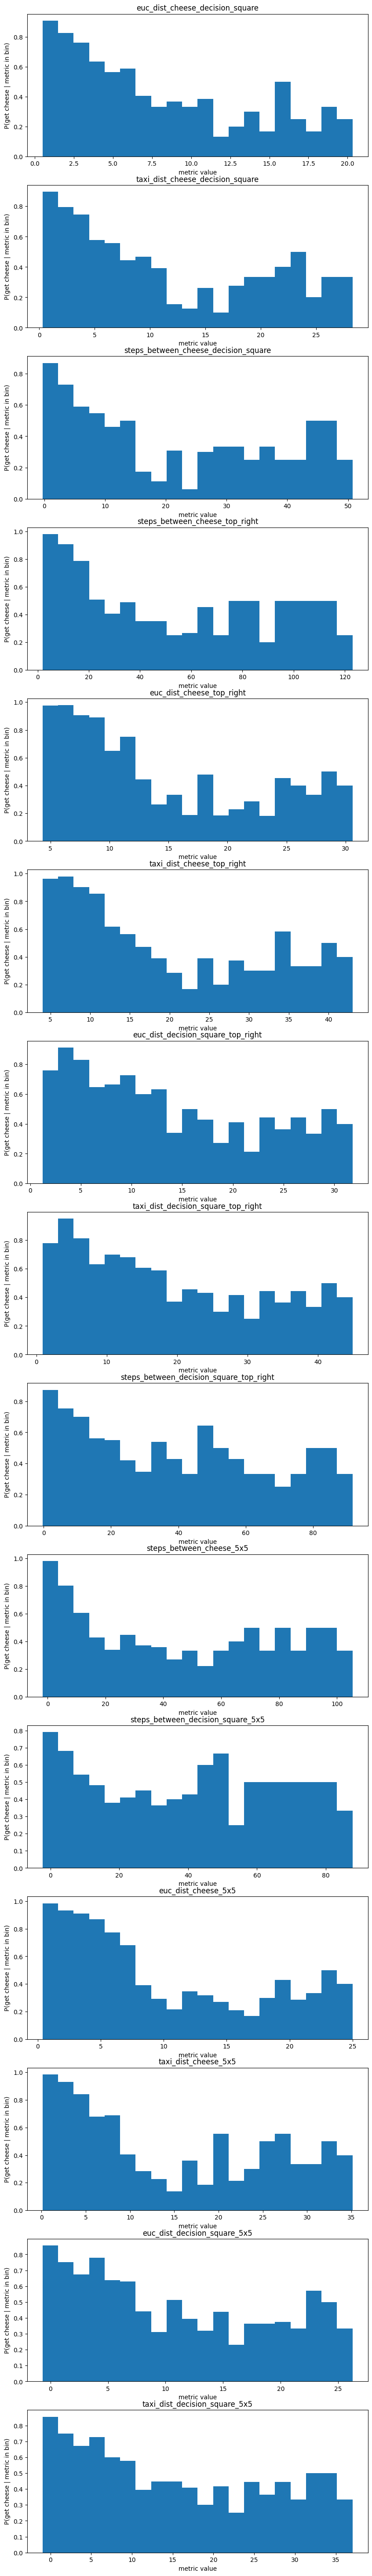

In [47]:
# Use matplotlib to plot all recorded_metrics by name (key) vertically in a single figure
fig, ax = plt.subplots(len(recorded_metrics), 1, figsize=(10, 5*len(recorded_metrics)))
for i, (name, values) in enumerate(recorded_metrics.items()):
    bins, edges = np.histogram(values, bins=20)
    percentages = []
    for j, (num_runs_in_this_bin, edge) in enumerate(zip(bins, edges)):
        successes = sum(got_cheese[np.logical_and(values >= edges[j], values < edges[j+1])]) 
        # laplace's rule of succession avoids devision-by-zero,
        # and gives a better estimate of P(get cheese | metric in this bin).
        percentages.append((successes+1) / (num_runs_in_this_bin+2))
    ax[i].bar(edges[:-1], percentages, width=edges[1]-edges[0])
    ax[i].set_title(name)
    ax[i].set_xlabel('metric value')
    ax[i].set_ylabel(f'P(get cheese | metric in bin)')
  
plt.show()